In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

STOCK_TICKER_TO_TEST = 'AAPL'
SEQUENCE_LENGTH_TO_TEST = 100
LSTM_UNITS_TO_TEST = 50
K_FEATURES_TO_TEST = 5

DATA_DIR = '../data'
LSTM_MODEL_DIR = '../models_lstm'
SPLIT_RATIO = 0.8

DATA_FILE_TO_TEST = os.path.join(DATA_DIR, f"{STOCK_TICKER_TO_TEST}.csv")
MODEL_FILENAME = f"lstm_{STOCK_TICKER_TO_TEST}_seq{SEQUENCE_LENGTH_TO_TEST}_units{LSTM_UNITS_TO_TEST}_k{K_FEATURES_TO_TEST}.keras"
MODEL_FILE_TO_TEST = os.path.join(LSTM_MODEL_DIR, MODEL_FILENAME)

print(f"Test edilecek model dosyası: {MODEL_FILE_TO_TEST}")
print(f"Kullanılacak veri dosyası: {DATA_FILE_TO_TEST}")

2025-07-28 18:16:11.564825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 18:16:11.584136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Test edilecek model dosyası: ../models_lstm/lstm_AAPL_seq100_units50_k5.keras
Kullanılacak veri dosyası: ../data/AAPL.csv


2025-07-28 18:16:12.240779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def load_and_clean_data(file_path):
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.dropna(how='any', inplace=True)
        price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        df = df[(df[price_cols] > 0).all(axis=1)]
        return df
    except Exception as e:
        return None

def feature_engineering(df):
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    delta = df['Close'].diff(1); gain = delta.where(delta > 0, 0); loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean(); avg_loss = loss.rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (avg_gain / avg_loss)))
    high_low = df['High'] - df['Low']; high_close = np.abs(df['High'] - df['Close'].shift()); low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    df['ATR'] = np.max(ranges, axis=1).rolling(window=14).mean()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean(); ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    sma_20 = df['Close'].rolling(window=20).mean(); std_20 = df['Close'].rolling(window=20).std()
    df['BB_upper'] = sma_20 + (std_20 * 2); df['BB_lower'] = sma_20 - (std_20 * 2)
    df['BB_width'] = df['BB_upper'] - df['BB_lower']
    df['ROC'] = ((df['Close'] - df['Close'].shift(14)) / df['Close'].shift(14)) * 100
    df['Target'] = (df['Close'] > df['Open']).astype(int)
    df['Target'] = df['Target'].shift(-1)
    df.dropna(inplace=True)
    df['Target'] = df['Target'].astype(int)
    return df

def create_lstm_sequences(X_data, y_data, sequence_length):
    X_sequences, y_sequences = [], []
    for i in range(len(X_data) - sequence_length):
        X_sequences.append(X_data[i:(i + sequence_length)])
        y_sequences.append(y_data[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

In [3]:
df_full = load_and_clean_data(DATA_FILE_TO_TEST)

try:
    model = load_model(MODEL_FILE_TO_TEST)
    print("Model başarıyla yüklendi.")
    model.summary()
except Exception as e:
    print(f"HATA: Model yüklenemedi! - {e}")
    model = None

Model başarıyla yüklendi.


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 100, 50)        │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,355 (368.58 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,904 (245.72 KB)

In [4]:
if df_full is not None and model is not None:
    df_featured = feature_engineering(df_full)
    X = df_featured.drop('Target', axis=1)
    y = df_featured['Target'].values

    split_index = int(len(X) * SPLIT_RATIO)
    X_train_raw, X_test_raw = X[:split_index], X[split_index:]
    y_train_raw, y_test_raw = y[:split_index], y[split_index:]
    
    selector = SelectKBest(f_classif, k=min(K_FEATURES_TO_TEST, X_train_raw.shape[1]))
    selector.fit(X_train_raw, y_train_raw)
    selected_cols = X_train_raw.columns[selector.get_support()]
    print(f"\nModelin kullandığı seçilmiş özellikler:\n{list(selected_cols)}")
    X_train_selected = X_train_raw[selected_cols]
    X_test_selected = X_test_raw[selected_cols]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)     

    X_test, y_test = create_lstm_sequences(X_test_scaled, y_test_raw, SEQUENCE_LENGTH_TO_TEST)
    
    print(f"\nTest verisi başarıyla hazırlandı. Test edilecek örnek sayısı: {len(X_test)}")


Modelin kullandığı seçilmiş özellikler:
['Open', 'High', 'Low', 'Volume', 'RSI']

Test verisi başarıyla hazırlandı. Test edilecek örnek sayısı: 1878



--- MODEL DEĞERLENDİRME SONUÇLARI ---

Modelin Test Verisi Üzerindeki Doğruluğu: 0.5218
Modelin Test Verisi Üzerindeki Kaybı    : 0.6929

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Sınıflandırma Raporu:
              precision    recall  f1-score   support

   Düşüş (0)       0.51      0.19      0.28       904
Yükseliş (1)       0.52      0.83      0.64       974

    accuracy                           0.52      1878
   macro avg       0.52      0.51      0.46      1878
weighted avg       0.52      0.52      0.47      1878

Karmaşıklık Matrisi:


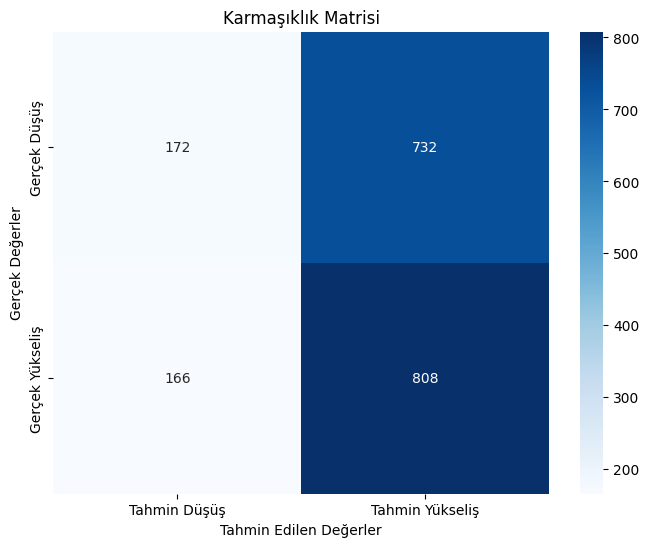

In [5]:
if 'model' in locals() and model is not None and 'X_test' in locals() and len(X_test) > 0:
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n--- MODEL DEĞERLENDİRME SONUÇLARI ---\n")
    print(f"Modelin Test Verisi Üzerindeki Doğruluğu: {test_accuracy:.4f}")
    print(f"Modelin Test Verisi Üzerindeki Kaybı    : {test_loss:.4f}\n")
    
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype("int32")

    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, y_pred, target_names=['Düşüş (0)', 'Yükseliş (1)']))

    print("Karmaşıklık Matrisi:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Tahmin Düşüş', 'Tahmin Yükseliş'],
                yticklabels=['Gerçek Düşüş', 'Gerçek Yükseliş'])
    plt.title('Karmaşıklık Matrisi')
    plt.ylabel('Gerçek Değerler')
    plt.xlabel('Tahmin Edilen Değerler')
    plt.show()